In [ ]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

In [4]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')  # Initialize the best accuracy to negative infinity
    best_f1 = -float('inf')  # Initialize the best F1-score to negative infinity
    best_model_state = None  # Store the state of the best model
    best_epoch = 0  # Track the epoch with the best accuracy
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # Calculate F1-score
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Check if the current model is the best based on F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Best Model was saved at epoch {best_epoch} with F1-score {best_f1:.4f} and accuracy {best_accuracy * 100:.2f}%")
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:51<00:00,  2.08it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [02:54<00:00,  1.39it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")


Data successfully split into training and test sets.


Training Epochs:   0%|          | 10/2500 [00:00<01:30, 27.63it/s]

Epoch 10/2500, Loss: 0.5042
Test Accuracy at Epoch 10: 57.89%
Test F1-score at Epoch 10: 0.3701
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.55      0.89      0.68       194
non_infringement       0.69      0.25      0.37       186

        accuracy                           0.58       380
       macro avg       0.62      0.57      0.53       380
    weighted avg       0.62      0.58      0.53       380

New best model saved with F1-score 0.3701 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.55      0.89      0.68       194
non_infringement       0.69      0.25      0.37       186

        accuracy                           0.58       380
       macro avg       0.62      0.57      0.53       380
    weighted avg       0.62      0.58      0.53       380



Training Epochs:   1%|          | 23/2500 [00:00<01:16, 32.26it/s]

Epoch 20/2500, Loss: 0.4632
Test Accuracy at Epoch 20: 62.89%
Test F1-score at Epoch 20: 0.7032
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.79      0.37      0.51       194
non_infringement       0.58      0.90      0.70       186

        accuracy                           0.63       380
       macro avg       0.68      0.63      0.60       380
    weighted avg       0.69      0.63      0.60       380

New best model saved with F1-score 0.7032 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.79      0.37      0.51       194
non_infringement       0.58      0.90      0.70       186

        accuracy                           0.63       380
       macro avg       0.68      0.63      0.60       380
    weighted avg       0.69      0.63      0.60       380



Training Epochs:   1%|▏         | 36/2500 [00:01<01:06, 37.32it/s]

Epoch 30/2500, Loss: 0.4456
Test Accuracy at Epoch 30: 64.47%
Test F1-score at Epoch 30: 0.6341
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.65      0.66      0.65       194
non_infringement       0.64      0.63      0.63       186

        accuracy                           0.64       380
       macro avg       0.64      0.64      0.64       380
    weighted avg       0.64      0.64      0.64       380



Training Epochs:   2%|▏         | 44/2500 [00:01<01:07, 36.14it/s]

Epoch 40/2500, Loss: 0.3990
Test Accuracy at Epoch 40: 67.63%
Test F1-score at Epoch 40: 0.6772
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.69      0.66      0.68       194
non_infringement       0.66      0.69      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:   2%|▏         | 54/2500 [00:01<01:01, 39.86it/s]

Epoch 50/2500, Loss: 0.3628
Test Accuracy at Epoch 50: 64.21%
Test F1-score at Epoch 50: 0.6531
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.67      0.60      0.63       194
non_infringement       0.62      0.69      0.65       186

        accuracy                           0.64       380
       macro avg       0.64      0.64      0.64       380
    weighted avg       0.64      0.64      0.64       380



Training Epochs:   3%|▎         | 63/2500 [00:01<01:08, 35.67it/s]

Epoch 60/2500, Loss: 0.3334
Test Accuracy at Epoch 60: 68.95%
Test F1-score at Epoch 60: 0.7035
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.73      0.63      0.67       194
non_infringement       0.66      0.75      0.70       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380

New best model saved with F1-score 0.7035 at epoch 60
Best Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.73      0.63      0.67       194
non_infringement       0.66      0.75      0.70       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:   3%|▎         | 77/2500 [00:02<01:07, 35.69it/s]

Epoch 70/2500, Loss: 0.3101
Test Accuracy at Epoch 70: 62.89%
Test F1-score at Epoch 70: 0.6299
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.64      0.61      0.63       194
non_infringement       0.62      0.65      0.63       186

        accuracy                           0.63       380
       macro avg       0.63      0.63      0.63       380
    weighted avg       0.63      0.63      0.63       380



Training Epochs:   3%|▎         | 82/2500 [00:02<01:20, 30.02it/s]

Epoch 80/2500, Loss: 0.2876
Test Accuracy at Epoch 80: 66.05%
Test F1-score at Epoch 80: 0.6684
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.68      0.62      0.65       194
non_infringement       0.64      0.70      0.67       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.66       380
    weighted avg       0.66      0.66      0.66       380



Training Epochs:   4%|▍         | 97/2500 [00:02<01:01, 38.77it/s]

Epoch 90/2500, Loss: 0.2666
Test Accuracy at Epoch 90: 65.00%
Test F1-score at Epoch 90: 0.6581
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.67      0.61      0.64       194
non_infringement       0.63      0.69      0.66       186

        accuracy                           0.65       380
       macro avg       0.65      0.65      0.65       380
    weighted avg       0.65      0.65      0.65       380



Training Epochs:   4%|▍         | 107/2500 [00:03<01:03, 37.91it/s]

Epoch 100/2500, Loss: 0.2469
Test Accuracy at Epoch 100: 66.05%
Test F1-score at Epoch 100: 0.6649
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.68      0.63      0.66       194
non_infringement       0.64      0.69      0.66       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.66       380
    weighted avg       0.66      0.66      0.66       380



Training Epochs:   4%|▍         | 112/2500 [00:03<01:02, 38.05it/s]

Epoch 110/2500, Loss: 0.2285
Test Accuracy at Epoch 110: 66.84%
Test F1-score at Epoch 110: 0.6753
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.69      0.63      0.66       194
non_infringement       0.65      0.70      0.68       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:   5%|▌         | 125/2500 [00:03<01:04, 36.97it/s]

Epoch 120/2500, Loss: 0.2110
Test Accuracy at Epoch 120: 67.11%
Test F1-score at Epoch 120: 0.6819
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       194
non_infringement       0.65      0.72      0.68       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:   6%|▌         | 138/2500 [00:03<01:02, 37.49it/s]

Epoch 130/2500, Loss: 0.4415
Test Accuracy at Epoch 130: 64.47%
Test F1-score at Epoch 130: 0.6110
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.63      0.72      0.67       194
non_infringement       0.66      0.57      0.61       186

        accuracy                           0.64       380
       macro avg       0.65      0.64      0.64       380
    weighted avg       0.65      0.64      0.64       380



Training Epochs:   6%|▌         | 142/2500 [00:04<01:09, 33.70it/s]

Epoch 140/2500, Loss: 0.2670
Test Accuracy at Epoch 140: 64.21%
Test F1-score at Epoch 140: 0.6222
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.64      0.68      0.66       194
non_infringement       0.64      0.60      0.62       186

        accuracy                           0.64       380
       macro avg       0.64      0.64      0.64       380
    weighted avg       0.64      0.64      0.64       380



Training Epochs:   6%|▌         | 151/2500 [00:04<01:07, 34.59it/s]

Epoch 150/2500, Loss: 0.1977
Test Accuracy at Epoch 150: 70.53%
Test F1-score at Epoch 150: 0.7295
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.68       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380

New best model saved with F1-score 0.7295 at epoch 150
Best Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.77      0.60      0.68       194
non_infringement       0.66      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:   7%|▋         | 165/2500 [00:04<01:05, 35.81it/s]

Epoch 160/2500, Loss: 0.1930
Test Accuracy at Epoch 160: 66.58%
Test F1-score at Epoch 160: 0.6735
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.69      0.63      0.66       194
non_infringement       0.65      0.70      0.67       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:   7%|▋         | 178/2500 [00:05<01:03, 36.38it/s]

Epoch 170/2500, Loss: 0.1753
Test Accuracy at Epoch 170: 66.32%
Test F1-score at Epoch 170: 0.6735
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.69      0.62      0.65       194
non_infringement       0.64      0.71      0.67       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:   7%|▋         | 182/2500 [00:05<01:11, 32.48it/s]

Epoch 180/2500, Loss: 0.1620
Test Accuracy at Epoch 180: 66.58%
Test F1-score at Epoch 180: 0.6701
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.69      0.64      0.66       194
non_infringement       0.65      0.69      0.67       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:   8%|▊         | 196/2500 [00:05<01:03, 36.17it/s]

Epoch 190/2500, Loss: 0.1570
Test Accuracy at Epoch 190: 66.32%
Test F1-score at Epoch 190: 0.6847
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.71      0.58      0.64       194
non_infringement       0.63      0.75      0.68       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:   8%|▊         | 204/2500 [00:05<01:04, 35.44it/s]

Epoch 200/2500, Loss: 0.3341
Test Accuracy at Epoch 200: 61.05%
Test F1-score at Epoch 200: 0.5488
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.60      0.73      0.66       194
non_infringement       0.63      0.48      0.55       186

        accuracy                           0.61       380
       macro avg       0.62      0.61      0.60       380
    weighted avg       0.61      0.61      0.60       380



Training Epochs:   9%|▊         | 213/2500 [00:06<01:08, 33.39it/s]

Epoch 210/2500, Loss: 0.1915
Test Accuracy at Epoch 210: 64.21%
Test F1-score at Epoch 210: 0.6158
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.64      0.70      0.67       194
non_infringement       0.65      0.59      0.62       186

        accuracy                           0.64       380
       macro avg       0.64      0.64      0.64       380
    weighted avg       0.64      0.64      0.64       380



Training Epochs:   9%|▉         | 222/2500 [00:06<01:02, 36.66it/s]

Epoch 220/2500, Loss: 0.1965
Test Accuracy at Epoch 220: 65.26%
Test F1-score at Epoch 220: 0.6508
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.66      0.64      0.65       194
non_infringement       0.64      0.66      0.65       186

        accuracy                           0.65       380
       macro avg       0.65      0.65      0.65       380
    weighted avg       0.65      0.65      0.65       380



Training Epochs:   9%|▉         | 235/2500 [00:06<01:01, 36.75it/s]

Epoch 230/2500, Loss: 0.1526
Test Accuracy at Epoch 230: 67.11%
Test F1-score at Epoch 230: 0.6944
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.72      0.58      0.64       194
non_infringement       0.64      0.76      0.69       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:  10%|▉         | 243/2500 [00:07<01:04, 34.96it/s]

Epoch 240/2500, Loss: 0.1424
Test Accuracy at Epoch 240: 65.79%
Test F1-score at Epoch 240: 0.6597
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.67      0.64      0.66       194
non_infringement       0.64      0.68      0.66       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.66       380
    weighted avg       0.66      0.66      0.66       380



Training Epochs:  10%|█         | 252/2500 [00:07<01:07, 33.11it/s]

Epoch 250/2500, Loss: 0.1345
Test Accuracy at Epoch 250: 65.79%
Test F1-score at Epoch 250: 0.6632
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.68      0.63      0.65       194
non_infringement       0.64      0.69      0.66       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.66       380
    weighted avg       0.66      0.66      0.66       380



Training Epochs:  11%|█         | 265/2500 [00:07<00:59, 37.54it/s]

Epoch 260/2500, Loss: 0.1296
Test Accuracy at Epoch 260: 66.84%
Test F1-score at Epoch 260: 0.6786
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       194
non_infringement       0.65      0.72      0.68       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:  11%|█         | 273/2500 [00:07<01:04, 34.63it/s]

Epoch 270/2500, Loss: 0.1246
Test Accuracy at Epoch 270: 67.11%
Test F1-score at Epoch 270: 0.6803
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       194
non_infringement       0.65      0.72      0.68       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:  11%|█▏        | 282/2500 [00:08<01:05, 33.71it/s]

Epoch 280/2500, Loss: 0.1211
Test Accuracy at Epoch 280: 67.11%
Test F1-score at Epoch 280: 0.6803
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       194
non_infringement       0.65      0.72      0.68       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:  12%|█▏        | 295/2500 [00:08<01:05, 33.56it/s]

Epoch 290/2500, Loss: 0.1181
Test Accuracy at Epoch 290: 67.89%
Test F1-score at Epoch 290: 0.6935
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.71      0.62      0.66       194
non_infringement       0.65      0.74      0.69       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  12%|█▏        | 305/2500 [00:08<00:59, 36.67it/s]

Epoch 300/2500, Loss: 0.1156
Test Accuracy at Epoch 300: 67.11%
Test F1-score at Epoch 300: 0.6803
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       194
non_infringement       0.65      0.72      0.68       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:  13%|█▎        | 313/2500 [00:09<01:03, 34.37it/s]

Epoch 310/2500, Loss: 0.1145
Test Accuracy at Epoch 310: 67.37%
Test F1-score at Epoch 310: 0.6821
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       194
non_infringement       0.65      0.72      0.68       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:  13%|█▎        | 322/2500 [00:09<01:05, 33.32it/s]

Epoch 320/2500, Loss: 0.6345
Test Accuracy at Epoch 320: 63.42%
Test F1-score at Epoch 320: 0.7192
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.89      0.32      0.48       194
non_infringement       0.58      0.96      0.72       186

        accuracy                           0.63       380
       macro avg       0.73      0.64      0.60       380
    weighted avg       0.73      0.63      0.59       380



Training Epochs:  13%|█▎        | 330/2500 [00:09<01:08, 31.85it/s]

Epoch 330/2500, Loss: 0.2819
Test Accuracy at Epoch 330: 67.11%
Test F1-score at Epoch 330: 0.7368
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.88      0.41      0.56       194
non_infringement       0.61      0.94      0.74       186

        accuracy                           0.67       380
       macro avg       0.74      0.68      0.65       380
    weighted avg       0.75      0.67      0.65       380

New best model saved with F1-score 0.7368 at epoch 330
Best Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.88      0.41      0.56       194
non_infringement       0.61      0.94      0.74       186

        accuracy                           0.67       380
       macro avg       0.74      0.68      0.65       380
    weighted avg       0.75      0.67      0.65       380



Training Epochs:  14%|█▍        | 345/2500 [00:09<01:01, 35.28it/s]

Epoch 340/2500, Loss: 0.2876
Test Accuracy at Epoch 340: 68.16%
Test F1-score at Epoch 340: 0.7231
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.78      0.52      0.63       194
non_infringement       0.63      0.85      0.72       186

        accuracy                           0.68       380
       macro avg       0.71      0.69      0.67       380
    weighted avg       0.71      0.68      0.67       380



Training Epochs:  14%|█▍        | 358/2500 [00:10<00:57, 37.31it/s]

Epoch 350/2500, Loss: 0.2349
Test Accuracy at Epoch 350: 68.95%
Test F1-score at Epoch 350: 0.7204
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.76      0.57      0.65       194
non_infringement       0.64      0.82      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.71      0.69      0.68       380



Training Epochs:  14%|█▍        | 362/2500 [00:10<00:56, 37.59it/s]

Epoch 360/2500, Loss: 0.2027
Test Accuracy at Epoch 360: 67.89%
Test F1-score at Epoch 360: 0.6888
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.71      0.63      0.67       194
non_infringement       0.66      0.73      0.69       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  15%|█▌        | 375/2500 [00:10<00:55, 38.07it/s]

Epoch 370/2500, Loss: 0.1809
Test Accuracy at Epoch 370: 67.11%
Test F1-score at Epoch 370: 0.6803
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       194
non_infringement       0.65      0.72      0.68       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:  16%|█▌        | 388/2500 [00:11<00:54, 38.68it/s]

Epoch 380/2500, Loss: 0.1660
Test Accuracy at Epoch 380: 67.89%
Test F1-score at Epoch 380: 0.6888
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.71      0.63      0.67       194
non_infringement       0.66      0.73      0.69       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  16%|█▌        | 393/2500 [00:11<01:00, 34.55it/s]

Epoch 390/2500, Loss: 0.1539
Test Accuracy at Epoch 390: 67.63%
Test F1-score at Epoch 390: 0.6854
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.67       194
non_infringement       0.65      0.72      0.69       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  16%|█▌        | 402/2500 [00:11<00:59, 35.30it/s]

Epoch 400/2500, Loss: 0.1448
Test Accuracy at Epoch 400: 67.63%
Test F1-score at Epoch 400: 0.6854
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.67       194
non_infringement       0.65      0.72      0.69       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  17%|█▋        | 415/2500 [00:11<00:56, 36.84it/s]

Epoch 410/2500, Loss: 0.1372
Test Accuracy at Epoch 410: 67.37%
Test F1-score at Epoch 410: 0.6837
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       194
non_infringement       0.65      0.72      0.68       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:  17%|█▋        | 424/2500 [00:12<00:58, 35.27it/s]

Epoch 420/2500, Loss: 0.1310
Test Accuracy at Epoch 420: 67.63%
Test F1-score at Epoch 420: 0.6870
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.71      0.63      0.66       194
non_infringement       0.65      0.73      0.69       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  17%|█▋        | 433/2500 [00:12<00:55, 37.35it/s]

Epoch 430/2500, Loss: 0.1260
Test Accuracy at Epoch 430: 67.37%
Test F1-score at Epoch 430: 0.6837
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.66       194
non_infringement       0.65      0.72      0.68       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:  18%|█▊        | 446/2500 [00:12<00:56, 36.56it/s]

Epoch 440/2500, Loss: 0.1218
Test Accuracy at Epoch 440: 68.42%
Test F1-score at Epoch 440: 0.6842
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.70      0.67      0.68       194
non_infringement       0.67      0.70      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  18%|█▊        | 455/2500 [00:13<00:58, 35.00it/s]

Epoch 450/2500, Loss: 0.2358
Test Accuracy at Epoch 450: 66.32%
Test F1-score at Epoch 450: 0.6541
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.67      0.68      0.67       194
non_infringement       0.66      0.65      0.65       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.66       380
    weighted avg       0.66      0.66      0.66       380



Training Epochs:  19%|█▊        | 464/2500 [00:13<00:59, 33.96it/s]

Epoch 460/2500, Loss: 0.4351
Test Accuracy at Epoch 460: 67.37%
Test F1-score at Epoch 460: 0.7269
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.81      0.47      0.59       194
non_infringement       0.62      0.89      0.73       186

        accuracy                           0.67       380
       macro avg       0.71      0.68      0.66       380
    weighted avg       0.72      0.67      0.66       380



Training Epochs:  19%|█▉        | 473/2500 [00:13<00:54, 37.28it/s]

Epoch 470/2500, Loss: 0.2283
Test Accuracy at Epoch 470: 66.58%
Test F1-score at Epoch 470: 0.6768
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.69      0.62      0.65       194
non_infringement       0.64      0.72      0.68       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:  19%|█▉        | 486/2500 [00:13<00:52, 38.08it/s]

Epoch 480/2500, Loss: 0.1648
Test Accuracy at Epoch 480: 67.63%
Test F1-score at Epoch 480: 0.6854
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.70      0.63      0.67       194
non_infringement       0.65      0.72      0.69       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  20%|█▉        | 495/2500 [00:14<00:56, 35.65it/s]

Epoch 490/2500, Loss: 0.1477
Test Accuracy at Epoch 490: 67.63%
Test F1-score at Epoch 490: 0.6917
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.71      0.61      0.66       194
non_infringement       0.65      0.74      0.69       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  20%|██        | 505/2500 [00:14<00:49, 40.00it/s]

Epoch 500/2500, Loss: 0.1351
Test Accuracy at Epoch 500: 67.89%
Test F1-score at Epoch 500: 0.6935
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.71      0.62      0.66       194
non_infringement       0.65      0.74      0.69       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  21%|██        | 515/2500 [00:14<00:51, 38.20it/s]

Epoch 510/2500, Loss: 0.1292
Test Accuracy at Epoch 510: 67.63%
Test F1-score at Epoch 510: 0.6902
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.71      0.62      0.66       194
non_infringement       0.65      0.74      0.69       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  21%|██        | 525/2500 [00:14<00:54, 36.43it/s]

Epoch 520/2500, Loss: 0.1247
Test Accuracy at Epoch 520: 67.63%
Test F1-score at Epoch 520: 0.6886
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.71      0.62      0.66       194
non_infringement       0.65      0.73      0.69       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  21%|██▏       | 535/2500 [00:15<00:49, 39.95it/s]

Epoch 530/2500, Loss: 0.1213
Test Accuracy at Epoch 530: 67.37%
Test F1-score at Epoch 530: 0.6853
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.70      0.62      0.66       194
non_infringement       0.65      0.73      0.69       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:  22%|██▏       | 545/2500 [00:15<00:51, 38.24it/s]

Epoch 540/2500, Loss: 0.1187
Test Accuracy at Epoch 540: 67.89%
Test F1-score at Epoch 540: 0.6919
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.71      0.62      0.66       194
non_infringement       0.65      0.74      0.69       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  22%|██▏       | 555/2500 [00:15<00:52, 36.82it/s]

Epoch 550/2500, Loss: 0.1165
Test Accuracy at Epoch 550: 67.63%
Test F1-score at Epoch 550: 0.6886
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.71      0.62      0.66       194
non_infringement       0.65      0.73      0.69       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  23%|██▎       | 565/2500 [00:16<00:49, 39.38it/s]

Epoch 560/2500, Loss: 0.1146
Test Accuracy at Epoch 560: 69.21%
Test F1-score at Epoch 560: 0.6992
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.72      0.65      0.68       194
non_infringement       0.67      0.73      0.70       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  23%|██▎       | 575/2500 [00:16<00:51, 37.19it/s]

Epoch 570/2500, Loss: 0.1130
Test Accuracy at Epoch 570: 69.21%
Test F1-score at Epoch 570: 0.6992
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.72      0.65      0.68       194
non_infringement       0.67      0.73      0.70       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  23%|██▎       | 584/2500 [00:16<00:56, 34.15it/s]

Epoch 580/2500, Loss: 0.1115
Test Accuracy at Epoch 580: 68.68%
Test F1-score at Epoch 580: 0.6941
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.71      0.65      0.68       194
non_infringement       0.67      0.73      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  24%|██▎       | 593/2500 [00:16<00:52, 36.06it/s]

Epoch 590/2500, Loss: 0.1103
Test Accuracy at Epoch 590: 69.74%
Test F1-score at Epoch 590: 0.6950
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.69      0.70      0.69       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  24%|██▍       | 601/2500 [00:17<01:02, 30.63it/s]

Epoch 600/2500, Loss: 0.1092
Test Accuracy at Epoch 600: 69.47%
Test F1-score at Epoch 600: 0.6931
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.68      0.70      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  25%|██▍       | 615/2500 [00:17<00:55, 33.71it/s]

Epoch 610/2500, Loss: 0.1082
Test Accuracy at Epoch 610: 69.21%
Test F1-score at Epoch 610: 0.6913
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.71      0.68      0.69       194
non_infringement       0.68      0.70      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  25%|██▍       | 624/2500 [00:17<00:57, 32.38it/s]

Epoch 620/2500, Loss: 0.1073
Test Accuracy at Epoch 620: 69.47%
Test F1-score at Epoch 620: 0.6931
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.68      0.70      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  25%|██▌       | 632/2500 [00:17<00:53, 34.70it/s]

Epoch 630/2500, Loss: 0.1065
Test Accuracy at Epoch 630: 69.47%
Test F1-score at Epoch 630: 0.6931
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.68      0.70      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  26%|██▌       | 645/2500 [00:18<00:50, 36.59it/s]

Epoch 640/2500, Loss: 0.1057
Test Accuracy at Epoch 640: 69.74%
Test F1-score at Epoch 640: 0.6950
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.69      0.70      0.69       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  26%|██▋       | 658/2500 [00:18<00:48, 38.05it/s]

Epoch 650/2500, Loss: 0.1051
Test Accuracy at Epoch 650: 69.47%
Test F1-score at Epoch 650: 0.6931
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.68      0.70      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  26%|██▋       | 662/2500 [00:18<00:48, 38.15it/s]

Epoch 660/2500, Loss: 0.1044
Test Accuracy at Epoch 660: 69.47%
Test F1-score at Epoch 660: 0.6931
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.68      0.70      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  27%|██▋       | 675/2500 [00:19<00:47, 38.72it/s]

Epoch 670/2500, Loss: 0.1039
Test Accuracy at Epoch 670: 69.74%
Test F1-score at Epoch 670: 0.6950
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.69      0.70      0.69       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  27%|██▋       | 684/2500 [00:19<00:48, 37.08it/s]

Epoch 680/2500, Loss: 0.1035
Test Accuracy at Epoch 680: 69.74%
Test F1-score at Epoch 680: 0.6950
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.69      0.70      0.69       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  28%|██▊       | 694/2500 [00:19<00:51, 34.87it/s]

Epoch 690/2500, Loss: 0.1049
Test Accuracy at Epoch 690: 68.95%
Test F1-score at Epoch 690: 0.6845
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.70      0.69      0.69       194
non_infringement       0.68      0.69      0.68       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  28%|██▊       | 703/2500 [00:19<00:48, 37.07it/s]

Epoch 700/2500, Loss: 0.1279
Test Accuracy at Epoch 700: 65.79%
Test F1-score at Epoch 700: 0.6845
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.71      0.56      0.63       194
non_infringement       0.62      0.76      0.68       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.65       380



Training Epochs:  28%|██▊       | 712/2500 [00:20<01:01, 29.09it/s]

Epoch 710/2500, Loss: 0.1130
Test Accuracy at Epoch 710: 66.84%
Test F1-score at Epoch 710: 0.6866
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.71      0.60      0.65       194
non_infringement       0.64      0.74      0.69       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:  29%|██▉       | 721/2500 [00:20<00:56, 31.41it/s]

Epoch 720/2500, Loss: 0.1071
Test Accuracy at Epoch 720: 66.58%
Test F1-score at Epoch 720: 0.6684
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.68      0.64      0.66       194
non_infringement       0.65      0.69      0.67       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:  29%|██▉       | 736/2500 [00:21<00:50, 35.16it/s]

Epoch 730/2500, Loss: 0.1037
Test Accuracy at Epoch 730: 67.11%
Test F1-score at Epoch 730: 0.6787
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.69      0.63      0.66       194
non_infringement       0.65      0.71      0.68       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:  30%|██▉       | 746/2500 [00:21<00:43, 40.71it/s]

Epoch 740/2500, Loss: 0.1036
Test Accuracy at Epoch 740: 68.68%
Test F1-score at Epoch 740: 0.6810
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.69      0.69      0.69       194
non_infringement       0.68      0.68      0.68       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  30%|███       | 757/2500 [00:21<00:42, 41.10it/s]

Epoch 750/2500, Loss: 0.1028
Test Accuracy at Epoch 750: 68.16%
Test F1-score at Epoch 750: 0.6773
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.69      0.68      0.69       194
non_infringement       0.67      0.68      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380

Epoch 760/2500, Loss: 0.1076


Training Epochs:  31%|███       | 767/2500 [00:21<00:43, 39.86it/s]

Test Accuracy at Epoch 760: 65.26%
Test F1-score at Epoch 760: 0.6667
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.68      0.60      0.64       194
non_infringement       0.63      0.71      0.67       186

        accuracy                           0.65       380
       macro avg       0.66      0.65      0.65       380
    weighted avg       0.66      0.65      0.65       380



Training Epochs:  31%|███       | 778/2500 [00:21<00:38, 44.61it/s]

Epoch 770/2500, Loss: 0.1064
Test Accuracy at Epoch 770: 68.42%
Test F1-score at Epoch 770: 0.6757
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.69      0.70      0.69       194
non_infringement       0.68      0.67      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  31%|███▏      | 783/2500 [00:22<00:43, 39.50it/s]

Epoch 780/2500, Loss: 0.1210
Test Accuracy at Epoch 780: 67.37%
Test F1-score at Epoch 780: 0.6961
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.72      0.59      0.65       194
non_infringement       0.64      0.76      0.70       186

        accuracy                           0.67       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:  32%|███▏      | 794/2500 [00:22<00:38, 44.77it/s]

Epoch 790/2500, Loss: 0.1030
Test Accuracy at Epoch 790: 67.37%
Test F1-score at Epoch 790: 0.6931
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.72      0.60      0.65       194
non_infringement       0.64      0.75      0.69       186

        accuracy                           0.67       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:  32%|███▏      | 806/2500 [00:22<00:38, 43.97it/s]

Epoch 800/2500, Loss: 0.1012
Test Accuracy at Epoch 800: 68.68%
Test F1-score at Epoch 800: 0.6860
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.70      0.68      0.69       194
non_infringement       0.67      0.70      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  32%|███▏      | 811/2500 [00:22<00:37, 44.60it/s]

Epoch 810/2500, Loss: 0.1034
Test Accuracy at Epoch 810: 69.74%
Test F1-score at Epoch 810: 0.6933
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.71      0.70      0.70       194
non_infringement       0.69      0.70      0.69       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  33%|███▎      | 828/2500 [00:23<00:38, 43.69it/s]

Epoch 820/2500, Loss: 0.1026
Test Accuracy at Epoch 820: 68.68%
Test F1-score at Epoch 820: 0.6957
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.71      0.64      0.68       194
non_infringement       0.66      0.73      0.70       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  33%|███▎      | 833/2500 [00:23<00:42, 38.93it/s]

Epoch 830/2500, Loss: 0.0999
Test Accuracy at Epoch 830: 69.21%
Test F1-score at Epoch 830: 0.6897
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.70      0.69      0.69       194
non_infringement       0.68      0.70      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  34%|███▍      | 844/2500 [00:23<00:38, 42.86it/s]

Epoch 840/2500, Loss: 0.1169
Test Accuracy at Epoch 840: 68.95%
Test F1-score at Epoch 840: 0.6828
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.70      0.70      0.70       194
non_infringement       0.68      0.68      0.68       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  34%|███▍      | 855/2500 [00:23<00:42, 38.66it/s]

Epoch 850/2500, Loss: 0.1115
Test Accuracy at Epoch 850: 68.42%
Test F1-score at Epoch 850: 0.6939
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.71      0.64      0.67       194
non_infringement       0.66      0.73      0.69       186

        accuracy                           0.68       380
       macro avg       0.69      0.69      0.68       380
    weighted avg       0.69      0.68      0.68       380



Training Epochs:  35%|███▍      | 865/2500 [00:24<00:44, 36.43it/s]

Epoch 860/2500, Loss: 0.1102
Test Accuracy at Epoch 860: 67.63%
Test F1-score at Epoch 860: 0.6963
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.72      0.60      0.65       194
non_infringement       0.64      0.76      0.70       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.68      0.68      0.67       380



Training Epochs:  35%|███▌      | 877/2500 [00:24<00:36, 44.86it/s]

Epoch 870/2500, Loss: 0.1001
Test Accuracy at Epoch 870: 70.26%
Test F1-score at Epoch 870: 0.7065
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.72      0.68      0.70       194
non_infringement       0.68      0.73      0.71       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380

Epoch 880/2500, Loss: 0.1003
Test Accuracy at Epoch 880: 69.74%
Test F1-score at Epoch 880: 0.6933
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.71      0.70      0.70       194
non_infringement       0.69      0.70      0.69       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  36%|███▌      | 893/2500 [00:24<00:36, 44.12it/s]

Epoch 890/2500, Loss: 0.0993
Test Accuracy at Epoch 890: 70.26%
Test F1-score at Epoch 890: 0.7065
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.72      0.68      0.70       194
non_infringement       0.68      0.73      0.71       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  36%|███▋      | 910/2500 [00:25<00:34, 46.27it/s]

Epoch 900/2500, Loss: 0.1022
Test Accuracy at Epoch 900: 68.68%
Test F1-score at Epoch 900: 0.6957
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.71      0.64      0.68       194
non_infringement       0.66      0.73      0.70       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380

Epoch 910/2500, Loss: 0.1010
Test Accuracy at Epoch 910: 68.68%
Test F1-score at Epoch 910: 0.6957
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.71      0.64      0.68       194
non_infringement       0.66      0.73      0.70       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  37%|███▋      | 929/2500 [00:25<00:32, 48.74it/s]

Epoch 920/2500, Loss: 0.0999
Test Accuracy at Epoch 920: 70.26%
Test F1-score at Epoch 920: 0.7065
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.72      0.68      0.70       194
non_infringement       0.68      0.73      0.71       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380

Epoch 930/2500, Loss: 0.1116
Test Accuracy at Epoch 930: 69.74%
Test F1-score at Epoch 930: 0.6933
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.71      0.70      0.70       194
non_infringement       0.69      0.70      0.69       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  38%|███▊      | 947/2500 [00:25<00:32, 47.13it/s]

Epoch 940/2500, Loss: 0.1003
Test Accuracy at Epoch 940: 69.74%
Test F1-score at Epoch 940: 0.6933
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.71      0.70      0.70       194
non_infringement       0.69      0.70      0.69       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380

Epoch 950/2500, Loss: 0.1050


Training Epochs:  38%|███▊      | 957/2500 [00:26<00:36, 42.48it/s]

Test Accuracy at Epoch 950: 68.68%
Test F1-score at Epoch 950: 0.6957
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.71      0.64      0.68       194
non_infringement       0.66      0.73      0.70       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  39%|███▉      | 969/2500 [00:26<00:31, 48.82it/s]

Epoch 960/2500, Loss: 0.1000
Test Accuracy at Epoch 960: 68.68%
Test F1-score at Epoch 960: 0.6957
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.71      0.64      0.68       194
non_infringement       0.66      0.73      0.70       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380

Epoch 970/2500, Loss: 0.0989
Test Accuracy at Epoch 970: 69.74%
Test F1-score at Epoch 970: 0.6950
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.69      0.70      0.69       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  39%|███▉      | 986/2500 [00:26<00:31, 47.34it/s]

Epoch 980/2500, Loss: 0.0982
Test Accuracy at Epoch 980: 70.26%
Test F1-score at Epoch 980: 0.7065
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.72      0.68      0.70       194
non_infringement       0.68      0.73      0.71       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  40%|███▉      | 997/2500 [00:27<00:32, 46.36it/s]

Epoch 990/2500, Loss: 0.1010
Test Accuracy at Epoch 990: 68.68%
Test F1-score at Epoch 990: 0.6957
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.71      0.64      0.68       194
non_infringement       0.66      0.73      0.70       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380

Epoch 1000/2500, Loss: 0.0990


Training Epochs:  40%|████      | 1003/2500 [00:27<00:31, 48.13it/s]

Test Accuracy at Epoch 1000: 68.68%
Test F1-score at Epoch 1000: 0.6957
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.71      0.64      0.68       194
non_infringement       0.66      0.73      0.70       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  41%|████      | 1020/2500 [00:27<00:31, 46.91it/s]

Epoch 1010/2500, Loss: 0.0979
Test Accuracy at Epoch 1010: 70.26%
Test F1-score at Epoch 1010: 0.7065
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.72      0.68      0.70       194
non_infringement       0.68      0.73      0.71       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380

Epoch 1020/2500, Loss: 0.0974
Test Accuracy at Epoch 1020: 70.26%
Test F1-score at Epoch 1020: 0.7065
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.72      0.68      0.70       194
non_infringement       0.68      0.73      0.71       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  42%|████▏     | 1038/2500 [00:27<00:31, 47.07it/s]

Epoch 1030/2500, Loss: 0.1057
Test Accuracy at Epoch 1030: 69.21%
Test F1-score at Epoch 1030: 0.6863
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.70      0.70      0.70       194
non_infringement       0.68      0.69      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380

Epoch 1040/2500, Loss: 0.0986
Test Accuracy at Epoch 1040: 69.47%
Test F1-score at Epoch 1040: 0.6931


Training Epochs:  42%|████▏     | 1048/2500 [00:28<00:33, 42.93it/s]

Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.68      0.70      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  42%|████▏     | 1060/2500 [00:28<00:30, 47.49it/s]

Epoch 1050/2500, Loss: 0.1032
Test Accuracy at Epoch 1050: 70.79%
Test F1-score at Epoch 1050: 0.7132
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.73      0.68      0.70       194
non_infringement       0.69      0.74      0.71       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380

Epoch 1060/2500, Loss: 0.0968
Test Accuracy at Epoch 1060: 68.68%
Test F1-score at Epoch 1060: 0.6957
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.71      0.64      0.68       194
non_infringement       0.66      0.73      0.70       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  43%|████▎     | 1076/2500 [00:28<00:29, 47.61it/s]

Epoch 1070/2500, Loss: 0.0967
Test Accuracy at Epoch 1070: 71.05%
Test F1-score at Epoch 1070: 0.7120
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.73      0.69      0.71       194
non_infringement       0.69      0.73      0.71       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380

Epoch 1080/2500, Loss: 0.0965
Test Accuracy at Epoch 1080: 69.74%
Test F1-score at Epoch 1080: 0.6950
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.69      0.70      0.69       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  44%|████▎     | 1093/2500 [00:29<00:29, 47.13it/s]

Epoch 1090/2500, Loss: 0.0988
Test Accuracy at Epoch 1090: 69.47%
Test F1-score at Epoch 1090: 0.6898
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.70      0.70      0.70       194
non_infringement       0.69      0.69      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  44%|████▍     | 1110/2500 [00:29<00:29, 46.79it/s]

Epoch 1100/2500, Loss: 0.0997
Test Accuracy at Epoch 1100: 68.42%
Test F1-score at Epoch 1100: 0.7044
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.73      0.60      0.66       194
non_infringement       0.65      0.77      0.70       186

        accuracy                           0.68       380
       macro avg       0.69      0.69      0.68       380
    weighted avg       0.69      0.68      0.68       380

Epoch 1110/2500, Loss: 0.1079
Test Accuracy at Epoch 1110: 69.47%
Test F1-score at Epoch 1110: 0.6898
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.70      0.70      0.70       194
non_infringement       0.69      0.69      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  45%|████▌     | 1128/2500 [00:29<00:29, 46.57it/s]

Epoch 1120/2500, Loss: 0.1040
Test Accuracy at Epoch 1120: 69.74%
Test F1-score at Epoch 1120: 0.6933
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.71      0.70      0.70       194
non_infringement       0.69      0.70      0.69       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380

Epoch 1130/2500, Loss: 0.0960
Test Accuracy at Epoch 1130: 71.05%
Test F1-score at Epoch 1130: 0.7120
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.73      0.69      0.71       194
non_infringement       0.69      0.73      0.71       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  46%|████▌     | 1145/2500 [00:30<00:29, 45.58it/s]

Epoch 1140/2500, Loss: 0.0969
Test Accuracy at Epoch 1140: 71.05%
Test F1-score at Epoch 1140: 0.7150
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.73      0.68      0.71       194
non_infringement       0.69      0.74      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380

Epoch 1150/2500, Loss: 0.0963
Test Accuracy at Epoch 1150: 69.74%
Test F1-score at Epoch 1150: 0.6950
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.69      0.70      0.69       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  47%|████▋     | 1167/2500 [00:30<00:27, 48.76it/s]

Epoch 1160/2500, Loss: 0.0955
Test Accuracy at Epoch 1160: 70.26%
Test F1-score at Epoch 1160: 0.7065
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.72      0.68      0.70       194
non_infringement       0.68      0.73      0.71       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380

Epoch 1170/2500, Loss: 0.0967
Test Accuracy at Epoch 1170: 69.21%
Test F1-score at Epoch 1170: 0.7023
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.72      0.64      0.68       194
non_infringement       0.67      0.74      0.70       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  47%|████▋     | 1177/2500 [00:31<00:31, 42.66it/s]

Epoch 1180/2500, Loss: 0.1044
Test Accuracy at Epoch 1180: 69.47%
Test F1-score at Epoch 1180: 0.6882
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.70      0.70      0.70       194
non_infringement       0.69      0.69      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  48%|████▊     | 1190/2500 [00:31<00:43, 30.43it/s]

Epoch 1190/2500, Loss: 0.0965
Test Accuracy at Epoch 1190: 69.47%
Test F1-score at Epoch 1190: 0.6898
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.70      0.70      0.70       194
non_infringement       0.69      0.69      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  48%|████▊     | 1198/2500 [00:32<01:11, 18.21it/s]

Epoch 1200/2500, Loss: 0.0962
Test Accuracy at Epoch 1200: 71.32%
Test F1-score at Epoch 1200: 0.7183
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.74      0.68      0.71       194
non_infringement       0.69      0.75      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  48%|████▊     | 1210/2500 [00:35<05:14,  4.10it/s]

Epoch 1210/2500, Loss: 0.0974
Test Accuracy at Epoch 1210: 71.05%
Test F1-score at Epoch 1210: 0.7165
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.74      0.68      0.70       194
non_infringement       0.69      0.75      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  49%|████▉     | 1225/2500 [00:40<03:16,  6.48it/s]

Epoch 1220/2500, Loss: 0.0962
Test Accuracy at Epoch 1220: 71.05%
Test F1-score at Epoch 1220: 0.7135
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.73      0.69      0.71       194
non_infringement       0.69      0.74      0.71       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  49%|████▉     | 1232/2500 [00:40<01:48, 11.68it/s]

Epoch 1230/2500, Loss: 0.0953
Test Accuracy at Epoch 1230: 70.53%
Test F1-score at Epoch 1230: 0.7098
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.73      0.68      0.70       194
non_infringement       0.69      0.74      0.71       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  50%|████▉     | 1238/2500 [00:40<01:06, 18.88it/s]

Epoch 1240/2500, Loss: 0.0973
Test Accuracy at Epoch 1240: 70.00%
Test F1-score at Epoch 1240: 0.6984
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.69      0.71      0.70       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  50%|████▉     | 1249/2500 [00:43<03:29,  5.96it/s]

Epoch 1250/2500, Loss: 0.0950
Test Accuracy at Epoch 1250: 70.00%
Test F1-score at Epoch 1250: 0.6984
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.69      0.71      0.70       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  50%|█████     | 1260/2500 [00:47<06:27,  3.20it/s]

Epoch 1260/2500, Loss: 0.1064
Test Accuracy at Epoch 1260: 69.74%
Test F1-score at Epoch 1260: 0.6933
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.71      0.70      0.70       194
non_infringement       0.69      0.70      0.69       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  51%|█████     | 1270/2500 [00:51<08:35,  2.38it/s]

Epoch 1270/2500, Loss: 0.0958
Test Accuracy at Epoch 1270: 70.00%
Test F1-score at Epoch 1270: 0.6984
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.69      0.71      0.70       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  51%|█████     | 1281/2500 [00:52<02:09,  9.40it/s]

Epoch 1280/2500, Loss: 0.1033
Test Accuracy at Epoch 1280: 69.47%
Test F1-score at Epoch 1280: 0.7056
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.73      0.64      0.68       194
non_infringement       0.67      0.75      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  52%|█████▏    | 1289/2500 [00:52<01:12, 16.61it/s]

Epoch 1290/2500, Loss: 0.1013
Test Accuracy at Epoch 1290: 69.47%
Test F1-score at Epoch 1290: 0.7056
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.73      0.64      0.68       194
non_infringement       0.67      0.75      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  52%|█████▏    | 1299/2500 [00:53<01:09, 17.19it/s]

Epoch 1300/2500, Loss: 0.0984
Test Accuracy at Epoch 1300: 71.05%
Test F1-score at Epoch 1300: 0.7165
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.74      0.68      0.70       194
non_infringement       0.69      0.75      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  52%|█████▏    | 1309/2500 [00:54<01:29, 13.38it/s]

Epoch 1310/2500, Loss: 0.0958
Test Accuracy at Epoch 1310: 71.32%
Test F1-score at Epoch 1310: 0.7198
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.74      0.68      0.71       194
non_infringement       0.69      0.75      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  53%|█████▎    | 1319/2500 [00:55<01:18, 15.12it/s]

Epoch 1320/2500, Loss: 0.0949
Test Accuracy at Epoch 1320: 71.05%
Test F1-score at Epoch 1320: 0.7135
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.73      0.69      0.71       194
non_infringement       0.69      0.74      0.71       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  53%|█████▎    | 1330/2500 [00:59<07:32,  2.59it/s]

Epoch 1330/2500, Loss: 0.0945
Test Accuracy at Epoch 1330: 70.79%
Test F1-score at Epoch 1330: 0.7117
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.73      0.68      0.70       194
non_infringement       0.69      0.74      0.71       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  54%|█████▎    | 1341/2500 [01:00<01:51, 10.40it/s]

Epoch 1340/2500, Loss: 0.0951
Test Accuracy at Epoch 1340: 70.00%
Test F1-score at Epoch 1340: 0.6984
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.69      0.71      0.70       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  54%|█████▍    | 1351/2500 [01:00<01:10, 16.27it/s]

Epoch 1350/2500, Loss: 0.0977
Test Accuracy at Epoch 1350: 70.00%
Test F1-score at Epoch 1350: 0.6984
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.69      0.71      0.70       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  55%|█████▍    | 1364/2500 [01:01<00:42, 26.42it/s]

Epoch 1360/2500, Loss: 0.0947
Test Accuracy at Epoch 1360: 70.00%
Test F1-score at Epoch 1360: 0.6984
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.69      0.71      0.70       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  55%|█████▍    | 1369/2500 [01:01<00:43, 25.98it/s]

Epoch 1370/2500, Loss: 0.0973
Test Accuracy at Epoch 1370: 71.32%
Test F1-score at Epoch 1370: 0.7154
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.73      0.69      0.71       194
non_infringement       0.70      0.74      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  55%|█████▌    | 1387/2500 [01:03<01:19, 14.06it/s]

Epoch 1380/2500, Loss: 0.0981
Test Accuracy at Epoch 1380: 70.00%
Test F1-score at Epoch 1380: 0.6968
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.71      0.70      0.70       194
non_infringement       0.69      0.70      0.70       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  56%|█████▌    | 1391/2500 [01:03<01:13, 15.12it/s]

Epoch 1390/2500, Loss: 0.0962
Test Accuracy at Epoch 1390: 69.21%
Test F1-score at Epoch 1390: 0.6880
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.70      0.69      0.70       194
non_infringement       0.68      0.69      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  56%|█████▌    | 1401/2500 [01:04<00:47, 22.98it/s]

Epoch 1400/2500, Loss: 0.1063
Test Accuracy at Epoch 1400: 68.68%
Test F1-score at Epoch 1400: 0.6792
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.69      0.70      0.69       194
non_infringement       0.68      0.68      0.68       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  57%|█████▋    | 1414/2500 [01:04<00:36, 29.77it/s]

Epoch 1410/2500, Loss: 0.0952
Test Accuracy at Epoch 1410: 66.32%
Test F1-score at Epoch 1410: 0.6735
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.69      0.62      0.65       194
non_infringement       0.64      0.71      0.67       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  57%|█████▋    | 1418/2500 [01:04<00:50, 21.32it/s]

Epoch 1420/2500, Loss: 0.0952
Test Accuracy at Epoch 1420: 70.00%
Test F1-score at Epoch 1420: 0.7031
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.72      0.68      0.70       194
non_infringement       0.68      0.73      0.70       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  57%|█████▋    | 1430/2500 [01:08<04:38,  3.84it/s]

Epoch 1430/2500, Loss: 0.0947
Test Accuracy at Epoch 1430: 70.00%
Test F1-score at Epoch 1430: 0.7031
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.72      0.68      0.70       194
non_infringement       0.68      0.73      0.70       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  58%|█████▊    | 1441/2500 [01:09<01:30, 11.65it/s]

Epoch 1440/2500, Loss: 0.0944
Test Accuracy at Epoch 1440: 70.00%
Test F1-score at Epoch 1440: 0.7031
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.72      0.68      0.70       194
non_infringement       0.68      0.73      0.70       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  58%|█████▊    | 1448/2500 [01:10<03:01,  5.80it/s]

Epoch 1450/2500, Loss: 0.0941
Test Accuracy at Epoch 1450: 70.00%
Test F1-score at Epoch 1450: 0.7016
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.72      0.68      0.70       194
non_infringement       0.68      0.72      0.70       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  58%|█████▊    | 1461/2500 [01:11<01:25, 12.13it/s]

Epoch 1460/2500, Loss: 0.0940
Test Accuracy at Epoch 1460: 70.26%
Test F1-score at Epoch 1460: 0.7034
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.72      0.69      0.70       194
non_infringement       0.69      0.72      0.70       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  59%|█████▉    | 1471/2500 [01:12<01:15, 13.54it/s]

Epoch 1470/2500, Loss: 0.0938
Test Accuracy at Epoch 1470: 69.74%
Test F1-score at Epoch 1470: 0.6997
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.72      0.68      0.69       194
non_infringement       0.68      0.72      0.70       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  59%|█████▉    | 1480/2500 [01:12<00:45, 22.23it/s]

Epoch 1480/2500, Loss: 0.0938
Test Accuracy at Epoch 1480: 69.21%
Test F1-score at Epoch 1480: 0.6880
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.70      0.69      0.70       194
non_infringement       0.68      0.69      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  60%|█████▉    | 1491/2500 [01:15<03:54,  4.30it/s]

Epoch 1490/2500, Loss: 0.0986
Test Accuracy at Epoch 1490: 68.95%
Test F1-score at Epoch 1490: 0.6828
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.70      0.70      0.70       194
non_infringement       0.68      0.68      0.68       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  60%|██████    | 1500/2500 [01:16<01:48,  9.24it/s]

Epoch 1500/2500, Loss: 0.1011
Test Accuracy at Epoch 1500: 69.21%
Test F1-score at Epoch 1500: 0.7053
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.73      0.63      0.68       194
non_infringement       0.66      0.75      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  60%|██████    | 1510/2500 [01:19<03:57,  4.16it/s]

Epoch 1510/2500, Loss: 0.0962
Test Accuracy at Epoch 1510: 70.00%
Test F1-score at Epoch 1510: 0.7016
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.72      0.68      0.70       194
non_infringement       0.68      0.72      0.70       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  61%|██████    | 1520/2500 [01:23<07:11,  2.27it/s]

Epoch 1520/2500, Loss: 0.0954
Test Accuracy at Epoch 1520: 69.47%
Test F1-score at Epoch 1520: 0.6898
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.70      0.70      0.70       194
non_infringement       0.69      0.69      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  61%|██████    | 1531/2500 [01:26<02:56,  5.48it/s]

Epoch 1530/2500, Loss: 0.0963
Test Accuracy at Epoch 1530: 68.16%
Test F1-score at Epoch 1530: 0.6905
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.71      0.64      0.67       194
non_infringement       0.66      0.73      0.69       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  62%|██████▏   | 1541/2500 [01:27<01:00, 15.85it/s]

Epoch 1540/2500, Loss: 0.0938
Test Accuracy at Epoch 1540: 70.26%
Test F1-score at Epoch 1540: 0.7050
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.72      0.68      0.70       194
non_infringement       0.69      0.73      0.70       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  62%|██████▏   | 1556/2500 [01:27<00:28, 32.57it/s]

Epoch 1550/2500, Loss: 0.0937
Test Accuracy at Epoch 1550: 70.79%
Test F1-score at Epoch 1550: 0.7087
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.72      0.69      0.71       194
non_infringement       0.69      0.73      0.71       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380

Epoch 1560/2500, Loss: 0.0953
Test Accuracy at Epoch 1560: 69.21%
Test F1-score at Epoch 1560: 0.6880
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.70      0.69      0.70       194
non_infringement       0.68      0.69      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  63%|██████▎   | 1572/2500 [01:27<00:23, 39.75it/s]

Epoch 1570/2500, Loss: 0.0935
Test Accuracy at Epoch 1570: 69.47%
Test F1-score at Epoch 1570: 0.6915
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.68      0.70      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  64%|██████▎   | 1589/2500 [01:28<00:21, 42.99it/s]

Epoch 1580/2500, Loss: 0.0982
Test Accuracy at Epoch 1580: 68.95%
Test F1-score at Epoch 1580: 0.6828
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.70      0.70      0.70       194
non_infringement       0.68      0.68      0.68       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  64%|██████▍   | 1594/2500 [01:28<00:23, 38.03it/s]

Epoch 1590/2500, Loss: 0.1037
Test Accuracy at Epoch 1590: 67.89%
Test F1-score at Epoch 1590: 0.6965
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.72      0.61      0.66       194
non_infringement       0.65      0.75      0.70       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  64%|██████▍   | 1606/2500 [01:28<00:19, 45.77it/s]

Epoch 1600/2500, Loss: 0.0937
Test Accuracy at Epoch 1600: 69.47%
Test F1-score at Epoch 1600: 0.7056
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.73      0.64      0.68       194
non_infringement       0.67      0.75      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380

Epoch 1610/2500, Loss: 0.0978


Training Epochs:  64%|██████▍   | 1611/2500 [01:28<00:23, 38.58it/s]

Test Accuracy at Epoch 1610: 67.63%
Test F1-score at Epoch 1610: 0.6737
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.69      0.67      0.68       194
non_infringement       0.66      0.68      0.67       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  65%|██████▍   | 1622/2500 [01:29<00:20, 43.38it/s]

Epoch 1620/2500, Loss: 0.0942
Test Accuracy at Epoch 1620: 68.68%
Test F1-score at Epoch 1620: 0.6941
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.71      0.65      0.68       194
non_infringement       0.67      0.73      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  65%|██████▌   | 1632/2500 [01:29<00:37, 22.96it/s]

Epoch 1630/2500, Loss: 0.0937
Test Accuracy at Epoch 1630: 67.89%
Test F1-score at Epoch 1630: 0.6806
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.70      0.66      0.68       194
non_infringement       0.66      0.70      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  66%|██████▌   | 1642/2500 [01:29<00:29, 28.96it/s]

Epoch 1640/2500, Loss: 0.0934
Test Accuracy at Epoch 1640: 67.37%
Test F1-score at Epoch 1640: 0.6771
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.69      0.65      0.67       194
non_infringement       0.66      0.70      0.68       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:  66%|██████▌   | 1656/2500 [01:30<00:23, 36.00it/s]

Epoch 1650/2500, Loss: 0.0953
Test Accuracy at Epoch 1650: 67.11%
Test F1-score at Epoch 1650: 0.6867
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.71      0.61      0.65       194
non_infringement       0.64      0.74      0.69       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:  66%|██████▋   | 1661/2500 [01:30<00:26, 32.03it/s]

Epoch 1660/2500, Loss: 0.0933
Test Accuracy at Epoch 1660: 68.16%
Test F1-score at Epoch 1660: 0.6824
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.70      0.66      0.68       194
non_infringement       0.67      0.70      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  67%|██████▋   | 1672/2500 [01:30<00:21, 37.75it/s]

Epoch 1670/2500, Loss: 0.0978
Test Accuracy at Epoch 1670: 67.89%
Test F1-score at Epoch 1670: 0.6789
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.69      0.66      0.68       194
non_infringement       0.66      0.69      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  67%|██████▋   | 1681/2500 [01:31<00:22, 36.00it/s]

Epoch 1680/2500, Loss: 0.0967
Test Accuracy at Epoch 1680: 67.89%
Test F1-score at Epoch 1680: 0.6839
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.70      0.65      0.67       194
non_infringement       0.66      0.71      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  68%|██████▊   | 1692/2500 [01:31<00:31, 25.73it/s]

Epoch 1690/2500, Loss: 0.0997
Test Accuracy at Epoch 1690: 68.95%
Test F1-score at Epoch 1690: 0.6828
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.70      0.70      0.70       194
non_infringement       0.68      0.68      0.68       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  68%|██████▊   | 1709/2500 [01:31<00:21, 37.50it/s]

Epoch 1700/2500, Loss: 0.0945
Test Accuracy at Epoch 1700: 67.63%
Test F1-score at Epoch 1700: 0.6789
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.69      0.65      0.67       194
non_infringement       0.66      0.70      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  69%|██████▊   | 1714/2500 [01:32<00:24, 31.92it/s]

Epoch 1710/2500, Loss: 0.0935
Test Accuracy at Epoch 1710: 68.68%
Test F1-score at Epoch 1710: 0.6941
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.71      0.65      0.68       194
non_infringement       0.67      0.73      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  69%|██████▉   | 1722/2500 [01:32<00:33, 23.22it/s]

Epoch 1720/2500, Loss: 0.0940
Test Accuracy at Epoch 1720: 67.11%
Test F1-score at Epoch 1720: 0.6753
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.69      0.64      0.67       194
non_infringement       0.65      0.70      0.68       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:  69%|██████▉   | 1732/2500 [01:32<00:25, 30.24it/s]

Epoch 1730/2500, Loss: 0.0945
Test Accuracy at Epoch 1730: 68.16%
Test F1-score at Epoch 1730: 0.6824
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.70      0.66      0.68       194
non_infringement       0.67      0.70      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  70%|██████▉   | 1741/2500 [01:33<00:28, 26.60it/s]

Epoch 1740/2500, Loss: 0.0934
Test Accuracy at Epoch 1740: 67.63%
Test F1-score at Epoch 1740: 0.6789
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.69      0.65      0.67       194
non_infringement       0.66      0.70      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  70%|███████   | 1750/2500 [01:36<02:35,  4.81it/s]

Epoch 1750/2500, Loss: 0.0975
Test Accuracy at Epoch 1750: 67.63%
Test F1-score at Epoch 1750: 0.6737
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.69      0.67      0.68       194
non_infringement       0.66      0.68      0.67       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  70%|███████   | 1758/2500 [01:37<01:31,  8.10it/s]

Epoch 1760/2500, Loss: 0.0944
Test Accuracy at Epoch 1760: 67.11%
Test F1-score at Epoch 1760: 0.6867
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.71      0.61      0.65       194
non_infringement       0.64      0.74      0.69       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:  71%|███████   | 1771/2500 [01:37<00:45, 16.16it/s]

Epoch 1770/2500, Loss: 0.0950
Test Accuracy at Epoch 1770: 67.63%
Test F1-score at Epoch 1770: 0.6737
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.69      0.67      0.68       194
non_infringement       0.66      0.68      0.67       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  71%|███████▏  | 1784/2500 [01:38<00:30, 23.10it/s]

Epoch 1780/2500, Loss: 0.0990
Test Accuracy at Epoch 1780: 67.11%
Test F1-score at Epoch 1780: 0.6867
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.71      0.61      0.65       194
non_infringement       0.64      0.74      0.69       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:  72%|███████▏  | 1788/2500 [01:38<00:29, 24.15it/s]

Epoch 1790/2500, Loss: 0.0936
Test Accuracy at Epoch 1790: 67.11%
Test F1-score at Epoch 1790: 0.6753
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.69      0.64      0.67       194
non_infringement       0.65      0.70      0.68       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:  72%|███████▏  | 1800/2500 [01:41<03:07,  3.74it/s]

Epoch 1800/2500, Loss: 0.0937
Test Accuracy at Epoch 1800: 67.89%
Test F1-score at Epoch 1800: 0.6806
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.70      0.66      0.68       194
non_infringement       0.66      0.70      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  72%|███████▏  | 1810/2500 [01:43<01:12,  9.56it/s]

Epoch 1810/2500, Loss: 0.0932
Test Accuracy at Epoch 1810: 67.89%
Test F1-score at Epoch 1810: 0.6806
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.70      0.66      0.68       194
non_infringement       0.66      0.70      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  73%|███████▎  | 1820/2500 [01:44<01:21,  8.34it/s]

Epoch 1820/2500, Loss: 0.0964
Test Accuracy at Epoch 1820: 67.37%
Test F1-score at Epoch 1820: 0.6720
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.69      0.66      0.68       194
non_infringement       0.66      0.68      0.67       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:  73%|███████▎  | 1830/2500 [01:47<03:30,  3.19it/s]

Epoch 1830/2500, Loss: 0.0931
Test Accuracy at Epoch 1830: 67.11%
Test F1-score at Epoch 1830: 0.6753
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.69      0.64      0.67       194
non_infringement       0.65      0.70      0.68       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:  74%|███████▎  | 1840/2500 [01:51<05:04,  2.17it/s]

Epoch 1840/2500, Loss: 0.1014
Test Accuracy at Epoch 1840: 67.11%
Test F1-score at Epoch 1840: 0.6867
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.71      0.61      0.65       194
non_infringement       0.64      0.74      0.69       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:  74%|███████▍  | 1850/2500 [01:55<04:11,  2.58it/s]

Epoch 1850/2500, Loss: 0.0941
Test Accuracy at Epoch 1850: 67.89%
Test F1-score at Epoch 1850: 0.6789
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.69      0.66      0.68       194
non_infringement       0.66      0.69      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  74%|███████▍  | 1861/2500 [01:56<00:56, 11.33it/s]

Epoch 1860/2500, Loss: 0.0978
Test Accuracy at Epoch 1860: 69.47%
Test F1-score at Epoch 1860: 0.7085
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.73      0.63      0.68       194
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  75%|███████▍  | 1873/2500 [01:56<00:31, 19.90it/s]

Epoch 1870/2500, Loss: 1.5926
Test Accuracy at Epoch 1870: 64.21%
Test F1-score at Epoch 1870: 0.7213
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.87      0.35      0.50       194
non_infringement       0.58      0.95      0.72       186

        accuracy                           0.64       380
       macro avg       0.73      0.65      0.61       380
    weighted avg       0.73      0.64      0.61       380



Training Epochs:  75%|███████▌  | 1883/2500 [01:57<00:26, 23.57it/s]

Epoch 1880/2500, Loss: 0.4573
Test Accuracy at Epoch 1880: 70.53%
Test F1-score at Epoch 1880: 0.7241
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       194
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.70       380
    weighted avg       0.71      0.71      0.70       380



Training Epochs:  76%|███████▌  | 1893/2500 [01:57<00:22, 27.26it/s]

Epoch 1890/2500, Loss: 0.3380
Test Accuracy at Epoch 1890: 69.74%
Test F1-score at Epoch 1890: 0.7013
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.72      0.67      0.69       194
non_infringement       0.68      0.73      0.70       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  76%|███████▌  | 1904/2500 [01:57<00:18, 32.84it/s]

Epoch 1900/2500, Loss: 0.3615
Test Accuracy at Epoch 1900: 66.05%
Test F1-score at Epoch 1900: 0.6799
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.70      0.59      0.64       194
non_infringement       0.63      0.74      0.68       186

        accuracy                           0.66       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.66      0.66       380



Training Epochs:  76%|███████▋  | 1908/2500 [01:57<00:23, 25.29it/s]

Epoch 1910/2500, Loss: 0.2912
Test Accuracy at Epoch 1910: 68.42%
Test F1-score at Epoch 1910: 0.6907
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.71      0.65      0.68       194
non_infringement       0.66      0.72      0.69       186

        accuracy                           0.68       380
       macro avg       0.69      0.68      0.68       380
    weighted avg       0.69      0.68      0.68       380



Training Epochs:  77%|███████▋  | 1920/2500 [02:03<03:18,  2.92it/s]

Epoch 1920/2500, Loss: 0.2795
Test Accuracy at Epoch 1920: 67.63%
Test F1-score at Epoch 1920: 0.6476
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.66      0.74      0.70       194
non_infringement       0.69      0.61      0.65       186

        accuracy                           0.68       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.68      0.67       380



Training Epochs:  77%|███████▋  | 1930/2500 [02:08<04:09,  2.29it/s]

Epoch 1930/2500, Loss: 0.2918
Test Accuracy at Epoch 1930: 67.89%
Test F1-score at Epoch 1930: 0.6630
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.68      0.71      0.69       194
non_infringement       0.68      0.65      0.66       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  78%|███████▊  | 1940/2500 [02:10<02:46,  3.36it/s]

Epoch 1940/2500, Loss: 0.2648
Test Accuracy at Epoch 1940: 70.53%
Test F1-score at Epoch 1940: 0.6957
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.71      0.72      0.71       194
non_infringement       0.70      0.69      0.70       186

        accuracy                           0.71       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  78%|███████▊  | 1950/2500 [02:14<03:55,  2.34it/s]

Epoch 1950/2500, Loss: 0.2523
Test Accuracy at Epoch 1950: 69.47%
Test F1-score at Epoch 1950: 0.6796
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.69      0.73      0.71       194
non_infringement       0.70      0.66      0.68       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  78%|███████▊  | 1961/2500 [02:17<02:08,  4.19it/s]

Epoch 1960/2500, Loss: 0.2302
Test Accuracy at Epoch 1960: 67.63%
Test F1-score at Epoch 1960: 0.6667
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.68      0.69      0.69       194
non_infringement       0.67      0.66      0.67       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  79%|███████▉  | 1976/2500 [02:17<00:27, 19.04it/s]

Epoch 1970/2500, Loss: 0.2235
Test Accuracy at Epoch 1970: 67.89%
Test F1-score at Epoch 1970: 0.6720
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.69      0.69      0.69       194
non_infringement       0.67      0.67      0.67       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380

Epoch 1980/2500, Loss: 0.2091
Test Accuracy at Epoch 1980: 69.47%
Test F1-score at Epoch 1980: 0.6931
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.68      0.70      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  80%|███████▉  | 1995/2500 [02:18<00:17, 29.70it/s]

Epoch 1990/2500, Loss: 0.2009
Test Accuracy at Epoch 1990: 68.16%
Test F1-score at Epoch 1990: 0.6739
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.69      0.69      0.69       194
non_infringement       0.68      0.67      0.67       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  80%|████████  | 2000/2500 [02:18<00:14, 33.46it/s]

Epoch 2000/2500, Loss: 0.1812
Test Accuracy at Epoch 2000: 68.95%
Test F1-score at Epoch 2000: 0.6845
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.70      0.69      0.69       194
non_infringement       0.68      0.69      0.68       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  81%|████████  | 2013/2500 [02:18<00:16, 29.30it/s]

Epoch 2010/2500, Loss: 0.1617
Test Accuracy at Epoch 2010: 71.32%
Test F1-score at Epoch 2010: 0.7046
Classification Report at Epoch 2010:
                  precision    recall  f1-score   support

    infringement       0.72      0.73      0.72       194
non_infringement       0.71      0.70      0.70       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  81%|████████  | 2020/2500 [02:18<00:15, 31.44it/s]

Epoch 2020/2500, Loss: 0.1455
Test Accuracy at Epoch 2020: 69.74%
Test F1-score at Epoch 2020: 0.6849
Classification Report at Epoch 2020:
                  precision    recall  f1-score   support

    infringement       0.70      0.72      0.71       194
non_infringement       0.70      0.67      0.68       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  81%|████████  | 2028/2500 [02:19<00:18, 25.38it/s]

Epoch 2030/2500, Loss: 0.1676
Test Accuracy at Epoch 2030: 70.79%
Test F1-score at Epoch 2030: 0.6959
Classification Report at Epoch 2030:
                  precision    recall  f1-score   support

    infringement       0.71      0.73      0.72       194
non_infringement       0.71      0.68      0.70       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  82%|████████▏ | 2040/2500 [02:19<00:18, 24.90it/s]

Epoch 2040/2500, Loss: 0.1559
Test Accuracy at Epoch 2040: 69.21%
Test F1-score at Epoch 2040: 0.6741
Classification Report at Epoch 2040:
                  precision    recall  f1-score   support

    infringement       0.69      0.73      0.71       194
non_infringement       0.70      0.65      0.67       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  82%|████████▏ | 2057/2500 [02:21<00:21, 20.63it/s]

Epoch 2050/2500, Loss: 0.1462
Test Accuracy at Epoch 2050: 70.53%
Test F1-score at Epoch 2050: 0.6940
Classification Report at Epoch 2050:
                  precision    recall  f1-score   support

    infringement       0.70      0.73      0.72       194
non_infringement       0.71      0.68      0.69       186

        accuracy                           0.71       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  82%|████████▏ | 2061/2500 [02:21<00:20, 21.66it/s]

Epoch 2060/2500, Loss: 0.1376
Test Accuracy at Epoch 2060: 70.79%
Test F1-score at Epoch 2060: 0.6959
Classification Report at Epoch 2060:
                  precision    recall  f1-score   support

    infringement       0.71      0.73      0.72       194
non_infringement       0.71      0.68      0.70       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  83%|████████▎ | 2075/2500 [02:21<00:14, 28.51it/s]

Epoch 2070/2500, Loss: 0.1305
Test Accuracy at Epoch 2070: 70.79%
Test F1-score at Epoch 2070: 0.6975
Classification Report at Epoch 2070:
                  precision    recall  f1-score   support

    infringement       0.71      0.73      0.72       194
non_infringement       0.71      0.69      0.70       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  83%|████████▎ | 2079/2500 [02:21<00:13, 30.87it/s]

Epoch 2080/2500, Loss: 0.1335
Test Accuracy at Epoch 2080: 71.05%
Test F1-score at Epoch 2080: 0.7011
Classification Report at Epoch 2080:
                  precision    recall  f1-score   support

    infringement       0.71      0.73      0.72       194
non_infringement       0.71      0.69      0.70       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  84%|████████▍ | 2094/2500 [02:22<00:16, 25.14it/s]

Epoch 2090/2500, Loss: 0.1848
Test Accuracy at Epoch 2090: 70.53%
Test F1-score at Epoch 2090: 0.7098
Classification Report at Epoch 2090:
                  precision    recall  f1-score   support

    infringement       0.73      0.68      0.70       194
non_infringement       0.69      0.74      0.71       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  84%|████████▍ | 2098/2500 [02:22<00:16, 24.79it/s]

Epoch 2100/2500, Loss: 0.1652
Test Accuracy at Epoch 2100: 67.89%
Test F1-score at Epoch 2100: 0.6856
Classification Report at Epoch 2100:
                  precision    recall  f1-score   support

    infringement       0.70      0.64      0.67       194
non_infringement       0.66      0.72      0.69       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  84%|████████▍ | 2110/2500 [02:23<00:26, 14.80it/s]

Epoch 2110/2500, Loss: 0.1686
Test Accuracy at Epoch 2110: 67.89%
Test F1-score at Epoch 2110: 0.6755
Classification Report at Epoch 2110:
                  precision    recall  f1-score   support

    infringement       0.69      0.68      0.68       194
non_infringement       0.67      0.68      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  85%|████████▍ | 2120/2500 [02:24<00:28, 13.49it/s]

Epoch 2120/2500, Loss: 0.1621
Test Accuracy at Epoch 2120: 68.16%
Test F1-score at Epoch 2120: 0.6756
Classification Report at Epoch 2120:
                  precision    recall  f1-score   support

    infringement       0.69      0.69      0.69       194
non_infringement       0.67      0.68      0.68       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  85%|████████▌ | 2131/2500 [02:25<00:18, 19.96it/s]

Epoch 2130/2500, Loss: 0.1555
Test Accuracy at Epoch 2130: 69.47%
Test F1-score at Epoch 2130: 0.6947
Classification Report at Epoch 2130:
                  precision    recall  f1-score   support

    infringement       0.71      0.68      0.69       194
non_infringement       0.68      0.71      0.69       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  85%|████████▌ | 2137/2500 [02:25<00:18, 19.68it/s]

Epoch 2140/2500, Loss: 0.1504
Test Accuracy at Epoch 2140: 69.47%
Test F1-score at Epoch 2140: 0.6947
Classification Report at Epoch 2140:
                  precision    recall  f1-score   support

    infringement       0.71      0.68      0.69       194
non_infringement       0.68      0.71      0.69       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  86%|████████▌ | 2155/2500 [02:26<00:13, 25.93it/s]

Epoch 2150/2500, Loss: 0.1446
Test Accuracy at Epoch 2150: 69.21%
Test F1-score at Epoch 2150: 0.6929
Classification Report at Epoch 2150:
                  precision    recall  f1-score   support

    infringement       0.71      0.68      0.69       194
non_infringement       0.68      0.71      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  87%|████████▋ | 2164/2500 [02:26<00:10, 31.50it/s]

Epoch 2160/2500, Loss: 0.1409
Test Accuracy at Epoch 2160: 68.68%
Test F1-score at Epoch 2160: 0.6860
Classification Report at Epoch 2160:
                  precision    recall  f1-score   support

    infringement       0.70      0.68      0.69       194
non_infringement       0.67      0.70      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  87%|████████▋ | 2175/2500 [02:26<00:08, 36.57it/s]

Epoch 2170/2500, Loss: 0.1447
Test Accuracy at Epoch 2170: 68.95%
Test F1-score at Epoch 2170: 0.6895
Classification Report at Epoch 2170:
                  precision    recall  f1-score   support

    infringement       0.70      0.68      0.69       194
non_infringement       0.68      0.70      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  87%|████████▋ | 2180/2500 [02:26<00:08, 35.69it/s]

Epoch 2180/2500, Loss: 0.1408
Test Accuracy at Epoch 2180: 67.63%
Test F1-score at Epoch 2180: 0.6720
Classification Report at Epoch 2180:
                  precision    recall  f1-score   support

    infringement       0.69      0.68      0.68       194
non_infringement       0.67      0.68      0.67       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  88%|████████▊ | 2190/2500 [02:27<00:11, 27.69it/s]

Epoch 2190/2500, Loss: 0.1376
Test Accuracy at Epoch 2190: 69.21%
Test F1-score at Epoch 2190: 0.6929
Classification Report at Epoch 2190:
                  precision    recall  f1-score   support

    infringement       0.71      0.68      0.69       194
non_infringement       0.68      0.71      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  88%|████████▊ | 2199/2500 [02:30<01:01,  4.90it/s]

Epoch 2200/2500, Loss: 0.1348
Test Accuracy at Epoch 2200: 69.21%
Test F1-score at Epoch 2200: 0.6913
Classification Report at Epoch 2200:
                  precision    recall  f1-score   support

    infringement       0.71      0.68      0.69       194
non_infringement       0.68      0.70      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  88%|████████▊ | 2207/2500 [02:31<00:43,  6.71it/s]

Epoch 2210/2500, Loss: 0.1321
Test Accuracy at Epoch 2210: 68.68%
Test F1-score at Epoch 2210: 0.6860
Classification Report at Epoch 2210:
                  precision    recall  f1-score   support

    infringement       0.70      0.68      0.69       194
non_infringement       0.67      0.70      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  89%|████████▉ | 2220/2500 [02:34<01:21,  3.42it/s]

Epoch 2220/2500, Loss: 0.1293
Test Accuracy at Epoch 2220: 68.68%
Test F1-score at Epoch 2220: 0.6860
Classification Report at Epoch 2220:
                  precision    recall  f1-score   support

    infringement       0.70      0.68      0.69       194
non_infringement       0.67      0.70      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  89%|████████▉ | 2230/2500 [02:39<02:06,  2.13it/s]

Epoch 2230/2500, Loss: 0.1255
Test Accuracy at Epoch 2230: 68.68%
Test F1-score at Epoch 2230: 0.6860
Classification Report at Epoch 2230:
                  precision    recall  f1-score   support

    infringement       0.70      0.68      0.69       194
non_infringement       0.67      0.70      0.69       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380



Training Epochs:  90%|████████▉ | 2240/2500 [02:43<01:42,  2.54it/s]

Epoch 2240/2500, Loss: 0.1264
Test Accuracy at Epoch 2240: 65.53%
Test F1-score at Epoch 2240: 0.6562
Classification Report at Epoch 2240:
                  precision    recall  f1-score   support

    infringement       0.67      0.64      0.65       194
non_infringement       0.64      0.67      0.66       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.66       380
    weighted avg       0.66      0.66      0.66       380



Training Epochs:  90%|█████████ | 2256/2500 [02:44<00:14, 16.77it/s]

Epoch 2250/2500, Loss: 0.1244
Test Accuracy at Epoch 2250: 65.79%
Test F1-score at Epoch 2250: 0.6579
Classification Report at Epoch 2250:
                  precision    recall  f1-score   support

    infringement       0.67      0.64      0.66       194
non_infringement       0.64      0.67      0.66       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.66       380
    weighted avg       0.66      0.66      0.66       380



Training Epochs:  90%|█████████ | 2259/2500 [02:44<00:23, 10.36it/s]

Epoch 2260/2500, Loss: 0.1227
Test Accuracy at Epoch 2260: 65.00%
Test F1-score at Epoch 2260: 0.6509
Classification Report at Epoch 2260:
                  precision    recall  f1-score   support

    infringement       0.66      0.63      0.65       194
non_infringement       0.64      0.67      0.65       186

        accuracy                           0.65       380
       macro avg       0.65      0.65      0.65       380
    weighted avg       0.65      0.65      0.65       380



Training Epochs:  91%|█████████ | 2270/2500 [02:49<01:42,  2.25it/s]

Epoch 2270/2500, Loss: 0.1210
Test Accuracy at Epoch 2270: 65.53%
Test F1-score at Epoch 2270: 0.6544
Classification Report at Epoch 2270:
                  precision    recall  f1-score   support

    infringement       0.67      0.64      0.66       194
non_infringement       0.64      0.67      0.65       186

        accuracy                           0.66       380
       macro avg       0.66      0.66      0.66       380
    weighted avg       0.66      0.66      0.66       380



Training Epochs:  91%|█████████ | 2279/2500 [02:51<00:35,  6.19it/s]

Epoch 2280/2500, Loss: 0.1222
Test Accuracy at Epoch 2280: 66.58%
Test F1-score at Epoch 2280: 0.6684
Classification Report at Epoch 2280:
                  precision    recall  f1-score   support

    infringement       0.68      0.64      0.66       194
non_infringement       0.65      0.69      0.67       186

        accuracy                           0.67       380
       macro avg       0.67      0.67      0.67       380
    weighted avg       0.67      0.67      0.67       380



Training Epochs:  92%|█████████▏| 2294/2500 [02:54<00:23,  8.91it/s]

Epoch 2290/2500, Loss: 0.1420
Test Accuracy at Epoch 2290: 64.74%
Test F1-score at Epoch 2290: 0.6510
Classification Report at Epoch 2290:
                  precision    recall  f1-score   support

    infringement       0.66      0.62      0.64       194
non_infringement       0.63      0.67      0.65       186

        accuracy                           0.65       380
       macro avg       0.65      0.65      0.65       380
    weighted avg       0.65      0.65      0.65       380



Training Epochs:  92%|█████████▏| 2300/2500 [02:55<00:23,  8.43it/s]

Epoch 2300/2500, Loss: 0.2166
Test Accuracy at Epoch 2300: 67.63%
Test F1-score at Epoch 2300: 0.6685
Classification Report at Epoch 2300:
                  precision    recall  f1-score   support

    infringement       0.68      0.69      0.68       194
non_infringement       0.67      0.67      0.67       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  92%|█████████▏| 2310/2500 [02:55<00:14, 13.34it/s]

Epoch 2310/2500, Loss: 0.5474
Test Accuracy at Epoch 2310: 68.68%
Test F1-score at Epoch 2310: 0.7302
Classification Report at Epoch 2310:
                  precision    recall  f1-score   support

    infringement       0.80      0.52      0.63       194
non_infringement       0.63      0.87      0.73       186

        accuracy                           0.69       380
       macro avg       0.72      0.69      0.68       380
    weighted avg       0.72      0.69      0.68       380



Training Epochs:  93%|█████████▎| 2326/2500 [02:56<00:08, 20.46it/s]

Epoch 2320/2500, Loss: 0.4477
Test Accuracy at Epoch 2320: 67.63%
Test F1-score at Epoch 2320: 0.7106
Classification Report at Epoch 2320:
                  precision    recall  f1-score   support

    infringement       0.75      0.55      0.63       194
non_infringement       0.63      0.81      0.71       186

        accuracy                           0.68       380
       macro avg       0.69      0.68      0.67       380
    weighted avg       0.69      0.68      0.67       380



Training Epochs:  93%|█████████▎| 2330/2500 [02:56<00:07, 21.69it/s]

Epoch 2330/2500, Loss: 0.5928
Test Accuracy at Epoch 2330: 63.95%
Test F1-score at Epoch 2330: 0.7243
Classification Report at Epoch 2330:
                  precision    recall  f1-score   support

    infringement       0.91      0.32      0.48       194
non_infringement       0.58      0.97      0.72       186

        accuracy                           0.64       380
       macro avg       0.75      0.65      0.60       380
    weighted avg       0.75      0.64      0.60       380



Training Epochs:  94%|█████████▎| 2340/2500 [02:58<00:17,  9.31it/s]

Epoch 2340/2500, Loss: 0.6405
Test Accuracy at Epoch 2340: 62.63%
Test F1-score at Epoch 2340: 0.7137
Classification Report at Epoch 2340:
                  precision    recall  f1-score   support

    infringement       0.87      0.31      0.46       194
non_infringement       0.57      0.95      0.71       186

        accuracy                           0.63       380
       macro avg       0.72      0.63      0.59       380
    weighted avg       0.72      0.63      0.59       380



Training Epochs:  94%|█████████▍| 2353/2500 [02:59<00:08, 17.06it/s]

Epoch 2350/2500, Loss: 0.4772
Test Accuracy at Epoch 2350: 67.37%
Test F1-score at Epoch 2350: 0.7328
Classification Report at Epoch 2350:
                  precision    recall  f1-score   support

    infringement       0.84      0.44      0.58       194
non_infringement       0.61      0.91      0.73       186

        accuracy                           0.67       380
       macro avg       0.73      0.68      0.66       380
    weighted avg       0.73      0.67      0.66       380

Epoch 2360/2500, Loss: 0.4703


Training Epochs:  95%|█████████▍| 2364/2500 [02:59<00:05, 23.10it/s]

Test Accuracy at Epoch 2360: 68.95%
Test F1-score at Epoch 2360: 0.7511
Classification Report at Epoch 2360:
                  precision    recall  f1-score   support

    infringement       0.91      0.43      0.59       194
non_infringement       0.62      0.96      0.75       186

        accuracy                           0.69       380
       macro avg       0.77      0.69      0.67       380
    weighted avg       0.77      0.69      0.67       380

New best model saved with F1-score 0.7511 at epoch 2360
Best Classification Report at Epoch 2360:
                  precision    recall  f1-score   support

    infringement       0.91      0.43      0.59       194
non_infringement       0.62      0.96      0.75       186

        accuracy                           0.69       380
       macro avg       0.77      0.69      0.67       380
    weighted avg       0.77      0.69      0.67       380



Training Epochs:  95%|█████████▍| 2374/2500 [02:59<00:04, 27.62it/s]

Epoch 2370/2500, Loss: 0.4728
Test Accuracy at Epoch 2370: 66.32%
Test F1-score at Epoch 2370: 0.7344
Classification Report at Epoch 2370:
                  precision    recall  f1-score   support

    infringement       0.89      0.39      0.54       194
non_infringement       0.60      0.95      0.73       186

        accuracy                           0.66       380
       macro avg       0.75      0.67      0.64       380
    weighted avg       0.75      0.66      0.63       380



Training Epochs:  95%|█████████▌| 2385/2500 [02:59<00:03, 36.40it/s]

Epoch 2380/2500, Loss: 0.4686
Test Accuracy at Epoch 2380: 64.47%
Test F1-score at Epoch 2380: 0.7273
Classification Report at Epoch 2380:
                  precision    recall  f1-score   support

    infringement       0.92      0.34      0.49       194
non_infringement       0.58      0.97      0.73       186

        accuracy                           0.64       380
       macro avg       0.75      0.65      0.61       380
    weighted avg       0.75      0.64      0.61       380



Training Epochs:  96%|█████████▌| 2394/2500 [03:00<00:03, 29.10it/s]

Epoch 2390/2500, Loss: 0.4607
Test Accuracy at Epoch 2390: 65.53%
Test F1-score at Epoch 2390: 0.7332
Classification Report at Epoch 2390:
                  precision    recall  f1-score   support

    infringement       0.92      0.36      0.51       194
non_infringement       0.59      0.97      0.73       186

        accuracy                           0.66       380
       macro avg       0.76      0.66      0.62       380
    weighted avg       0.76      0.66      0.62       380



Training Epochs:  96%|█████████▋| 2408/2500 [03:00<00:02, 33.09it/s]

Epoch 2400/2500, Loss: 0.4418
Test Accuracy at Epoch 2400: 68.95%
Test F1-score at Epoch 2400: 0.7122
Classification Report at Epoch 2400:
                  precision    recall  f1-score   support

    infringement       0.74      0.60      0.66       194
non_infringement       0.65      0.78      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  97%|█████████▋| 2418/2500 [03:01<00:02, 35.74it/s]

Epoch 2410/2500, Loss: 0.4133
Test Accuracy at Epoch 2410: 68.68%
Test F1-score at Epoch 2410: 0.6987
Classification Report at Epoch 2410:
                  precision    recall  f1-score   support

    infringement       0.72      0.63      0.67       194
non_infringement       0.66      0.74      0.70       186

        accuracy                           0.69       380
       macro avg       0.69      0.69      0.69       380
    weighted avg       0.69      0.69      0.69       380

Epoch 2420/2500, Loss: 0.4311
Test Accuracy at Epoch 2420: 70.79%
Test F1-score at Epoch 2420: 0.7633
Classification Report at Epoch 2420:
                  precision    recall  f1-score   support

    infringement       0.93      0.46      0.62       194
non_infringement       0.63      0.96      0.76       186

        accuracy                           0.71       380
       macro avg       0.78      0.71      0.69       380
    weighted avg       0.78      0.71      0.69       380

New best model saved

Training Epochs:  97%|█████████▋| 2432/2500 [03:01<00:02, 23.57it/s]

Epoch 2430/2500, Loss: 0.4349
Test Accuracy at Epoch 2430: 63.68%
Test F1-score at Epoch 2430: 0.7229
Classification Report at Epoch 2430:
                  precision    recall  f1-score   support

    infringement       0.91      0.32      0.47       194
non_infringement       0.58      0.97      0.72       186

        accuracy                           0.64       380
       macro avg       0.74      0.64      0.60       380
    weighted avg       0.75      0.64      0.60       380



Training Epochs:  98%|█████████▊| 2438/2500 [03:02<00:02, 22.54it/s]

Epoch 2440/2500, Loss: 0.4252
Test Accuracy at Epoch 2440: 71.32%
Test F1-score at Epoch 2440: 0.7625
Classification Report at Epoch 2440:
                  precision    recall  f1-score   support

    infringement       0.90      0.49      0.64       194
non_infringement       0.64      0.94      0.76       186

        accuracy                           0.71       380
       macro avg       0.77      0.72      0.70       380
    weighted avg       0.77      0.71      0.70       380



Training Epochs:  98%|█████████▊| 2452/2500 [03:04<00:04, 11.06it/s]

Epoch 2450/2500, Loss: 0.3786
Test Accuracy at Epoch 2450: 67.37%
Test F1-score at Epoch 2450: 0.7075
Classification Report at Epoch 2450:
                  precision    recall  f1-score   support

    infringement       0.75      0.55      0.63       194
non_infringement       0.63      0.81      0.71       186

        accuracy                           0.67       380
       macro avg       0.69      0.68      0.67       380
    weighted avg       0.69      0.67      0.67       380



Training Epochs:  99%|█████████▊| 2463/2500 [03:04<00:01, 19.34it/s]

Epoch 2460/2500, Loss: 0.4159
Test Accuracy at Epoch 2460: 70.26%
Test F1-score at Epoch 2460: 0.7570
Classification Report at Epoch 2460:
                  precision    recall  f1-score   support

    infringement       0.90      0.47      0.62       194
non_infringement       0.63      0.95      0.76       186

        accuracy                           0.70       380
       macro avg       0.77      0.71      0.69       380
    weighted avg       0.77      0.70      0.69       380



Training Epochs:  99%|█████████▉| 2473/2500 [03:04<00:01, 25.50it/s]

Epoch 2470/2500, Loss: 0.4095
Test Accuracy at Epoch 2470: 70.53%
Test F1-score at Epoch 2470: 0.7586
Classification Report at Epoch 2470:
                  precision    recall  f1-score   support

    infringement       0.90      0.47      0.62       194
non_infringement       0.63      0.95      0.76       186

        accuracy                           0.71       380
       macro avg       0.77      0.71      0.69       380
    weighted avg       0.77      0.71      0.69       380



Training Epochs:  99%|█████████▉| 2487/2500 [03:05<00:00, 35.11it/s]

Epoch 2480/2500, Loss: 0.4031
Test Accuracy at Epoch 2480: 72.89%
Test F1-score at Epoch 2480: 0.7736
Classification Report at Epoch 2480:
                  precision    recall  f1-score   support

    infringement       0.91      0.52      0.66       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.73      0.72       380
    weighted avg       0.78      0.73      0.72       380

New best model saved with F1-score 0.7736 at epoch 2480
Best Classification Report at Epoch 2480:
                  precision    recall  f1-score   support

    infringement       0.91      0.52      0.66       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.73      0.72       380
    weighted avg       0.78      0.73      0.72       380



Training Epochs: 100%|█████████▉| 2497/2500 [03:05<00:00, 38.13it/s]

Epoch 2490/2500, Loss: 0.3969
Test Accuracy at Epoch 2490: 73.16%
Test F1-score at Epoch 2490: 0.7733
Classification Report at Epoch 2490:
                  precision    recall  f1-score   support

    infringement       0.90      0.54      0.67       194
non_infringement       0.66      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.74      0.72       380
    weighted avg       0.78      0.73      0.72       380



Training Epochs: 100%|██████████| 2500/2500 [03:05<00:00, 13.47it/s]
/tmp/ipykernel_3963944/2175062796.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

Epoch 2500/2500, Loss: 0.3904
Test Accuracy at Epoch 2500: 72.89%
Test F1-score at Epoch 2500: 0.7696
Classification Report at Epoch 2500:
                  precision    recall  f1-score   support

    infringement       0.88      0.54      0.67       194
non_infringement       0.66      0.92      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.73      0.72       380
    weighted avg       0.77      0.73      0.72       380



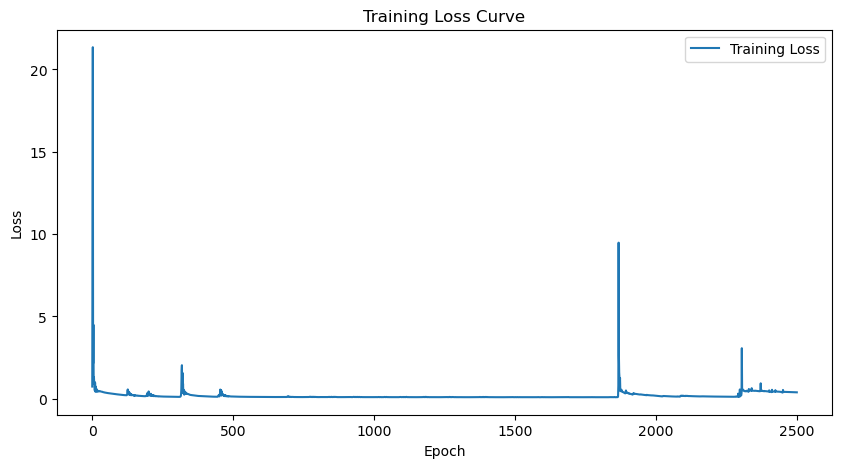

Best Model was saved at epoch 2480 with F1-score 0.7736 and accuracy 72.89%


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'.


In [ ]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 72.89%
                  precision    recall  f1-score   support

    infringement       0.91      0.52      0.66       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.73      0.72       380
    weighted avg       0.78      0.73      0.72       380



/tmp/ipykernel_3963944/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


: 